In [1]:
# Imports

import os
import json
import tqdm
import yaml

import torch
import numpy as np
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from pathlib import Path
from tqdm.auto import tqdm

/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%%bash
fusermount -uz /mnt/work/dhuseljic
sshfs cluster.ies:/mnt/work/dhuseljic/ /mnt/work/dhuseljic

In [3]:
def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def verify_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'

    result_json = path / 'results.json'
    if not result_json.is_file():
        raise ValueError()

def load_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
        
    results = {}

    exp_json = path / 'results.json'
    exp_cfg = path / '.hydra' / 'config.yaml'

    if exp_cfg.is_file():
        cfg =  OmegaConf.load(exp_cfg)
        results['cfg'] = cfg
    else:
        raise ValueError(f'Config missing for {exp_cfg}')

    if exp_json.is_file():
        data = load_json(exp_json)
        results['results'] = data
    else:
        raise ValueError(f'Results missing for {exp_json}')

    return results

def get_experiments(result_path, glob_pattern, verify_only=False):
    # Aggregate results over multiple glob pattern such as seeds
    experiments = []
    print('Searching in', result_path)
    exp_paths = list(result_path.glob(glob_pattern))
    if len(exp_paths) < 1:
        raise ValueError(f'No experiments found in {result_path}')
    for exp_path in exp_paths:
        print('> Found', exp_path.name)
        if verify_only:
            verify_results(exp_path)
            continue
        d = load_results(exp_path)
        experiments.append(d)
    # assert len(experiments) != 0, f'No experiments found for {result_path}.'
    return experiments

path = f'/mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{18}/'
exp_results = get_experiments(Path(path), 'seed1', verify_only=True)
exp_results = get_experiments(Path(path), 'seed1')
print(exp_results[0]['results']['cycle0'].keys())
print(exp_results[0]['results']['cycle0']['test_stats'].keys())

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT128__ACQ_SIZE128__N_ACQ18
> Found seed1
Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT128__ACQ_SIZE128__N_ACQ18
> Found seed1
dict_keys(['test_stats', 'labeled_indices', 'n_labeled_samples', 'unlabeled_indices', 'n_unlabeled_samples'])
dict_keys(['accuracy', 'nll', 'brier', 'tce', 'ace'])


## Aleatoric Results

In [13]:
root_path = Path('/mnt/work/dhuseljic/results/udal/')
# root_path = Path('/home/denis/results/udal/')
verify_only = False
dataset = 'CIFAR10'
model = 'resnet18'
experiments = {}
n_init = 128
acq_size = 128
num_cycles = 38
# Deterministic
experiments.update({
    'random eval':  root_path / f'active_learning/{dataset}/resnet18/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'lc eval':      root_path / f'active_learning/{dataset}/resnet18/least_confident/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'margin eval':  root_path / f'active_learning/{dataset}/resnet18/margin/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy eval': root_path / f'active_learning/{dataset}/resnet18/entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})

# # Labels smoothing
experiments.update({
    'random (ls)':  root_path / f'active_learning/{dataset}/resnet18_labelsmoothing/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'lc (ls)':      root_path / f'active_learning/{dataset}/resnet18_labelsmoothing/least_confident/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'margin (ls)':  root_path / f'active_learning/{dataset}/resnet18_labelsmoothing/margin/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy (ls)': root_path / f'active_learning/{dataset}/resnet18_labelsmoothing/entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    'random (ls) eval':     root_path / f'evaluation/{dataset}/resnet18_labelsmoothing/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'lc (ls) eval':         root_path / f'evaluation/{dataset}/resnet18_labelsmoothing/least_confident/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'margin (ls) eval':     root_path / f'evaluation/{dataset}/resnet18_labelsmoothing/margin/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy (ls) eval':    root_path / f'evaluation/{dataset}/resnet18_labelsmoothing/entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})
# 
# Mixup
experiments.update({
    'random (mixup)':   root_path / f'active_learning/{dataset}/resnet18_mixup/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'lc (mixup)':       root_path / f'active_learning/{dataset}/resnet18_mixup/least_confident/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'margin (mixup)':   root_path / f'active_learning/{dataset}/resnet18_mixup/margin/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy (mixup)':  root_path / f'active_learning/{dataset}/resnet18_mixup/entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    'random (mixup) eval':  root_path / f'evaluation/{dataset}/resnet18_mixup/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'lc (mixup) eval':      root_path / f'evaluation/{dataset}/resnet18_mixup/least_confident/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'margin (mixup) eval':  root_path / f'evaluation/{dataset}/resnet18_mixup/margin/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy (mixup) eval': root_path / f'evaluation/{dataset}/resnet18_mixup/entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})


all_results = {}
for exp_name, exp_path in experiments.items():
    all_results[exp_name] = get_experiments(Path(exp_path), 'seed*', verify_only=verify_only)

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed9
> Found seed3
> Found seed4
> Found seed10
> Found seed7
> Found seed5
> Found seed2
> Found seed8
> Found seed6
> Found seed1
Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/margin/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed6
> Found seed1
> Found seed5
> Found seed8
> Found seed2
> Found seed7
> Found seed3
> Found seed9
> Found seed4
> Found seed10
Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/random/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed7
> Found seed4
> Found seed9
> Found seed3
> Found seed1
> Found seed6
> Found seed2
> Found seed8
> Found seed10
> Found seed5
Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/margin/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed7
> Found seed9
> Found seed3
> Found seed4
> Found seed10
> Fo

100%|██████████| 10/10 [00:00<00:00, 206.08it/s]


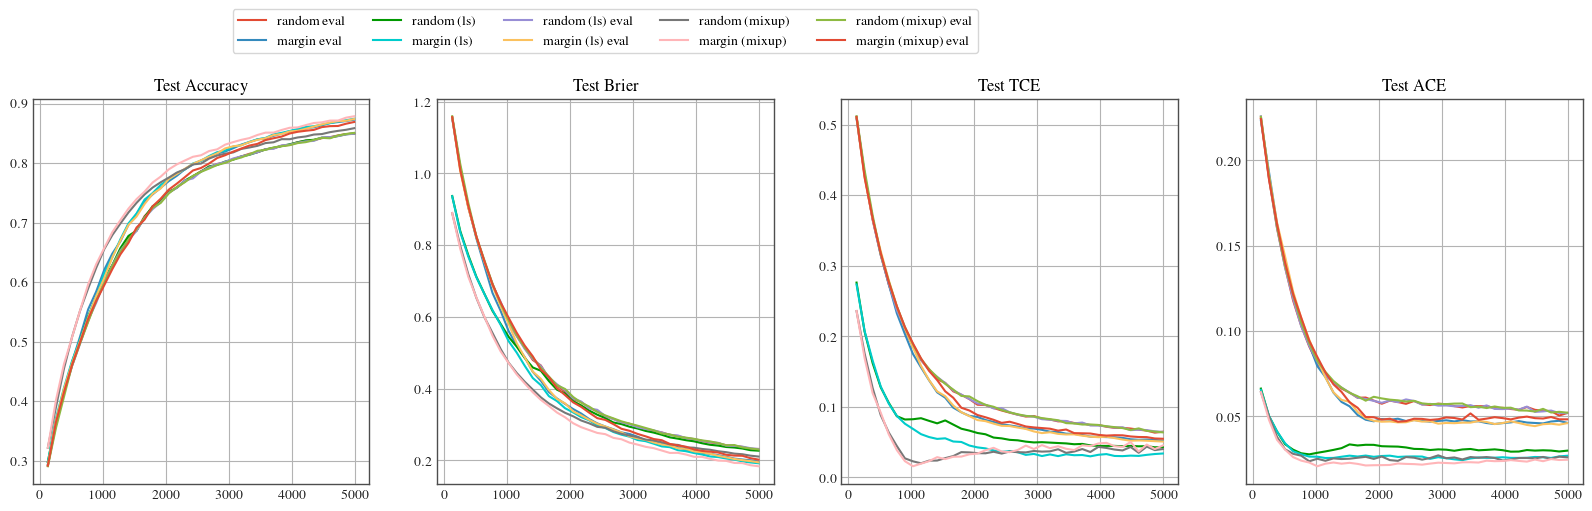

In [16]:
show_std = False
table_dict = {}
learning_curves = {}
plt.figure(figsize=(20, 5))
for strat_name, results in tqdm(all_results.items()):

    train_accs = []
    train_loss = []
    test_accs = []
    test_nll = []
    test_brier = []
    test_tce = []
    test_ace = []
    n_labeled_samples = []
    for seed_result in results:
        data = seed_result['results']
        # print(strat_name, data['cycle0']['labeled_indices'])

        # Get metric values of interest
        n_labeled_samples.append([data[cycle]['n_labeled_samples'] for cycle in data])
        # train_accs.append([data[cycle]['train_history'][-1]['train_acc1'] for cycle in data])
        # train_loss.append([data[cycle]['train_history'][-1]['train_loss'] for cycle in data])
        test_accs.append([data[cycle]['test_stats']['accuracy'] for cycle in data])
        test_nll.append([data[cycle]['test_stats']['nll'] for cycle in data])
        test_brier.append([data[cycle]['test_stats']['brier'] for cycle in data])
        test_tce.append([data[cycle]['test_stats']['tce'] for cycle in data])
        test_ace.append([data[cycle]['test_stats']['ace'] for cycle in data])

    n_labeled_samples = np.mean(n_labeled_samples, 0)
    # train_accs_mean, train_accs_std = np.mean(train_accs, 0), np.std(train_accs, 0)
    # train_loss_mean, train_loss_std = np.mean(train_loss, 0), np.std(train_loss, 0)
    test_accs_mean, test_accs_std = np.mean(test_accs, 0), np.std(test_accs, 0)
    test_nll_mean, test_nll_std = np.mean(test_nll, 0), np.std(test_nll, 0)
    test_brier_mean, test_brier_std = np.mean(test_brier, 0), np.std(test_brier, 0)
    test_tce_mean, test_tce_std = np.mean(test_tce, 0), np.std(test_tce, 0)
    test_ace_mean, test_ace_std = np.mean(test_ace, 0), np.std(test_ace, 0)

    learning_curves[strat_name] = {
        'acc': test_accs_mean, 'acc_std': test_accs_std,
        'nll': test_nll_mean, 'nll_std': test_nll_std,
        'brier': test_brier_mean, 'brier_std': test_brier_std,
        'tce': test_tce_mean, 'tce_std': test_tce_std,
        'ace': test_ace_mean, 'ace_std': test_ace_std,
    }

    table_dict[strat_name] = {
        'acc (Final)': test_accs_mean[-1], 
        'acc (AUC)': np.mean(test_accs_mean), 
        'nll (Final)': test_nll_mean[-1], 
        'nll (AUC)': np.mean(test_nll_mean), 
        'brier (Final)': test_brier_mean[-1], 
        'brier (AUC)': np.mean(test_brier_mean), 
        'TCE (Final)': test_tce_mean[-1],
        'TCE (AUC)': np.mean(test_tce_mean), 
        'ACE (Final)': test_ace_mean[-1],
        'ACE (AUC)': np.mean(test_ace_mean), 
    }

    plt.subplot(141)
    plt.title('Test Accuracy')
    plt.plot(n_labeled_samples, test_accs_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)
    plt.subplot(142)
    plt.title('Test Brier')
    plt.plot(n_labeled_samples, test_brier_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_brier_mean-test_brier_std, test_brier_mean+test_brier_std, alpha=.3)
    plt.subplot(143)
    plt.title('Test TCE')
    plt.plot(n_labeled_samples, test_tce_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_tce_mean-test_tce_std, test_tce_mean+test_tce_std, alpha=.3)
    plt.subplot(144)
    plt.title('Test ACE')
    plt.plot(n_labeled_samples, test_ace_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_ace_mean-test_ace_std, test_ace_mean+test_ace_std, alpha=.3)

    # plt.subplot(141)
    # plt.title('NLL')
    # plt.plot(test_accs_mean, test_nll_mean)
    # plt.subplot(142)
    # plt.title('Brier')
    # plt.plot(test_accs_mean, test_brier_mean)
    # plt.subplot(143)
    # plt.title('TCE')
    # plt.plot(test_accs_mean, test_tce_mean)
    # plt.subplot(144)
    # plt.title('ACE')
    # plt.plot(test_accs_mean, test_ace_mean)


plt.subplot(142).legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=5)
        

In [17]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict).T
print(df.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & acc (Final) & acc (AUC) & nll (Final) & nll (AUC) & brier (Final) & brier (AUC) & TCE (Final) & TCE (AUC) & ACE (Final) & ACE (AUC) \\
\midrule
random eval & 0.849 & 0.720 & 0.528 & 1.070 & 0.231 & 0.425 & 0.065 & 0.138 & 0.052 & 0.074 \\
margin eval & 0.873 & 0.738 & 0.441 & 0.998 & 0.196 & 0.398 & 0.052 & 0.124 & 0.046 & 0.068 \\
random (ls) & 0.850 & 0.721 & 0.537 & 0.926 & 0.227 & 0.395 & 0.043 & 0.073 & 0.030 & 0.032 \\
margin (ls) & 0.874 & 0.739 & 0.455 & 0.864 & 0.191 & 0.370 & 0.034 & 0.059 & 0.027 & 0.028 \\
random (ls) eval & 0.849 & 0.719 & 0.528 & 1.072 & 0.231 & 0.426 & 0.065 & 0.139 & 0.052 & 0.074 \\
margin (ls) eval & 0.874 & 0.738 & 0.435 & 1.000 & 0.194 & 0.399 & 0.051 & 0.124 & 0.046 & 0.068 \\
random (mixup) & 0.859 & 0.744 & 0.486 & 0.824 & 0.210 & 0.358 & 0.040 & 0.049 & 0.026 & 0.028 \\
margin (mixup) & 0.879 & 0.756 & 0.429 & 0.786 & 0.183 & 0.342 & 0.045 & 0.050 & 0.025 & 0.025 \\
random (mixup) eval & 0.851 & 0.719 & 0

In [18]:
print(df[['nll (AUC)', 'brier (AUC)', 'TCE (AUC)', 'ACE (AUC)']].to_latex(float_format="%.3f"))

\begin{tabular}{lrrrr}
\toprule
 & nll (AUC) & brier (AUC) & TCE (AUC) & ACE (AUC) \\
\midrule
random eval & 1.070 & 0.425 & 0.138 & 0.074 \\
margin eval & 0.998 & 0.398 & 0.124 & 0.068 \\
random (ls) & 0.926 & 0.395 & 0.073 & 0.032 \\
margin (ls) & 0.864 & 0.370 & 0.059 & 0.028 \\
random (ls) eval & 1.072 & 0.426 & 0.139 & 0.074 \\
margin (ls) eval & 1.000 & 0.399 & 0.124 & 0.068 \\
random (mixup) & 0.824 & 0.358 & 0.049 & 0.028 \\
margin (mixup) & 0.786 & 0.342 & 0.050 & 0.025 \\
random (mixup) eval & 1.078 & 0.427 & 0.140 & 0.075 \\
margin (mixup) eval & 1.031 & 0.412 & 0.129 & 0.070 \\
\bottomrule
\end{tabular}



In [19]:
print(df[['acc (Final)', 'acc (AUC)']].to_latex(float_format="%.3f"))

\begin{tabular}{lrr}
\toprule
 & acc (Final) & acc (AUC) \\
\midrule
random eval & 0.849 & 0.720 \\
margin eval & 0.873 & 0.738 \\
random (ls) & 0.850 & 0.721 \\
margin (ls) & 0.874 & 0.739 \\
random (ls) eval & 0.849 & 0.719 \\
margin (ls) eval & 0.874 & 0.738 \\
random (mixup) & 0.859 & 0.744 \\
margin (mixup) & 0.879 & 0.756 \\
random (mixup) eval & 0.851 & 0.719 \\
margin (mixup) eval & 0.869 & 0.728 \\
\bottomrule
\end{tabular}



In [20]:
# df1 = df[['nll (AUC)', 'brier (AUC)', 'TCE (AUC)', 'ACE (AUC)']]
df1 = df[['nll (Final)', 'brier (Final)', 'TCE (Final)', 'ACE (Final)']]
print(df1.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
 & nll (Final) & brier (Final) & TCE (Final) & ACE (Final) \\
\midrule
random eval & 0.53 & 0.23 & 0.06 & 0.05 \\
margin eval & 0.44 & 0.20 & 0.05 & 0.05 \\
random (ls) & 0.54 & 0.23 & 0.04 & 0.03 \\
margin (ls) & 0.45 & 0.19 & 0.03 & 0.03 \\
random (ls) eval & 0.53 & 0.23 & 0.06 & 0.05 \\
margin (ls) eval & 0.44 & 0.19 & 0.05 & 0.05 \\
random (mixup) & 0.49 & 0.21 & 0.04 & 0.03 \\
margin (mixup) & 0.43 & 0.18 & 0.05 & 0.02 \\
random (mixup) eval & 0.53 & 0.23 & 0.06 & 0.05 \\
margin (mixup) eval & 0.45 & 0.20 & 0.05 & 0.05 \\
\bottomrule
\end{tabular}



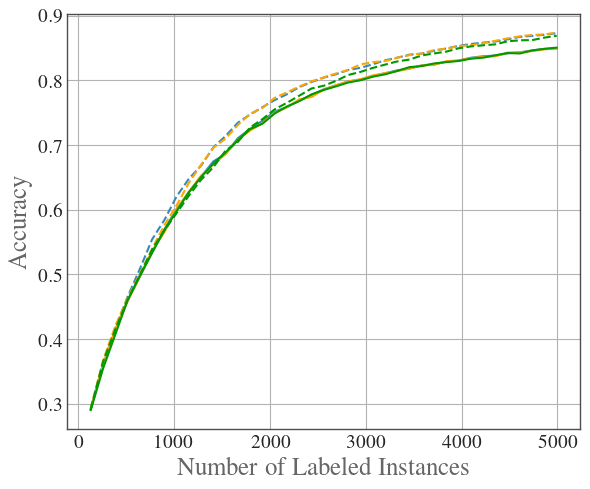

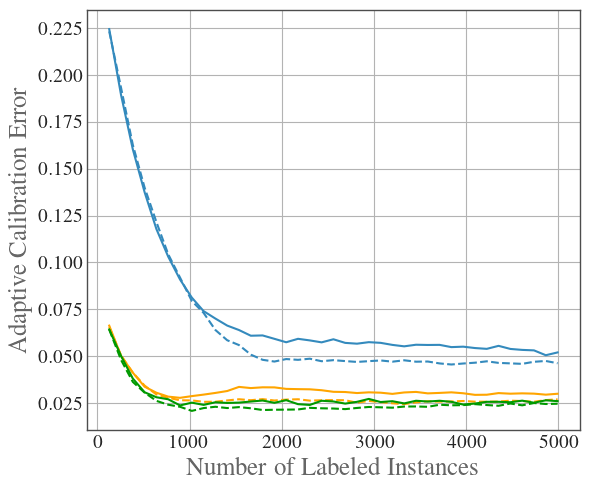

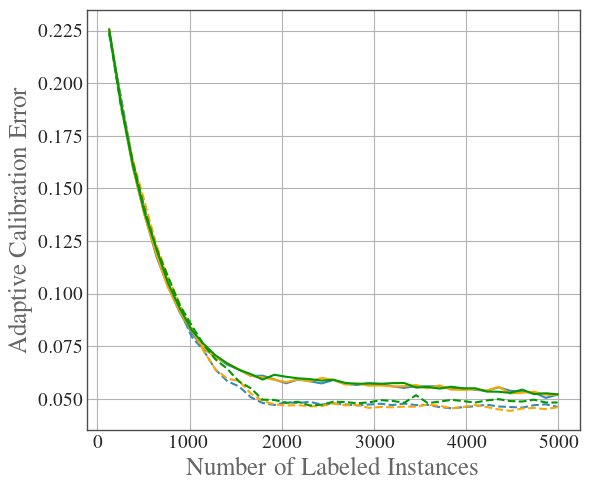

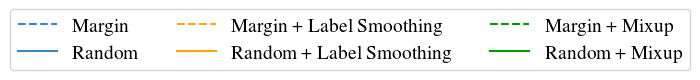

In [27]:
plt.figure(figsize=(6, 5))
plt.plot(n_labeled_samples, learning_curves['random eval']['acc'], '-', color='C1', label='random')
plt.plot(n_labeled_samples, learning_curves['margin eval']['acc'], '--', color='C1', label='margin')

plt.plot(n_labeled_samples, learning_curves['random (ls) eval']['acc'], '-', color='orange', label='random ls')
plt.plot(n_labeled_samples, learning_curves['margin (ls) eval']['acc'], '--', color='orange', label='margin ls')

plt.plot(n_labeled_samples, learning_curves['random (mixup) eval']['acc'], '-', color='C2', label='random mixup')
plt.plot(n_labeled_samples, learning_curves['margin (mixup) eval']['acc'], '--', color='C2', label='margin mixup')
plt.xticks(fontsize=14)
plt.xlabel('Number of Labeled Instances', fontdict={'size': 18})
plt.yticks(fontsize=14)
plt.ylabel('Accuracy', fontdict={'size': 18})
plt.tight_layout()
plt.savefig('plots_al/evaluation_acc.pdf', bbox_inches='tight', pad_inches=0) 

plt.figure(figsize=(6, 5))
plt.plot(n_labeled_samples, learning_curves['random eval']['ace'], '-', color='C1', label='random')
plt.plot(n_labeled_samples, learning_curves['margin eval']['ace'], '--', color='C1', label='margin')

plt.plot(n_labeled_samples, learning_curves['random (ls)']['ace'], '-', color='orange', label='random ls')
plt.plot(n_labeled_samples, learning_curves['margin (ls)']['ace'], '--', color='orange', label='margin ls')

plt.plot(n_labeled_samples, learning_curves['random (mixup)']['ace'], '-', color='C2', label='random mixup')
plt.plot(n_labeled_samples, learning_curves['margin (mixup)']['ace'], '--', color='C2', label='margin mixup')
plt.xticks(fontsize=14)
plt.xlabel('Number of Labeled Instances', fontdict={'size': 18})
plt.yticks(fontsize=14)
plt.ylabel('Adaptive Calibration Error', fontdict={'size': 18})
plt.tight_layout()
plt.savefig('plots_al/selection_ace.pdf', bbox_inches='tight', pad_inches=0) 

plt.figure(figsize=(6, 5))
plt.plot(n_labeled_samples, learning_curves['random eval']['ace'], '-', color='C1', label='random')
plt.plot(n_labeled_samples, learning_curves['margin eval']['ace'], '--', color='C1', label='margin')

plt.plot(n_labeled_samples, learning_curves['random (ls) eval']['ace'], '-', color='orange', label='random ls')
plt.plot(n_labeled_samples, learning_curves['margin (ls) eval']['ace'], '--', color='orange', label='margin ls')

plt.plot(n_labeled_samples, learning_curves['random (mixup) eval']['ace'], '-', color='C2', label='random mixup')
plt.plot(n_labeled_samples, learning_curves['margin (mixup) eval']['ace'], '--', color='C2', label='margin mixup')
plt.xticks(fontsize=14)
plt.xlabel('Number of Labeled Instances', fontdict={'size': 18})
plt.yticks(fontsize=14)
plt.ylabel('Adaptive Calibration Error', fontdict={'size': 18})
plt.tight_layout()
plt.savefig('plots_al/evaluation_ace.pdf', bbox_inches='tight', pad_inches=0) 

colors = {
    'margin': 'C1',
    'margin_ls': 'orange',
    'margin_mixup': 'C2',
}

fig = plt.figure()
plt.plot([], [], '--', label='Margin', color=colors['margin'])
plt.plot([], [], '-', label='Random', color=colors['margin'])
plt.plot([], [], '--', label='Margin + Label Smoothing', color=colors['margin_ls'])
plt.plot([], [], '-', label='Random + Label Smoothing', color=colors['margin_ls'])
plt.plot([], [], '--', label='Margin + Mixup', color=colors['margin_mixup'])
plt.plot([], [], '-', label='Random + Mixup', color=colors['margin_mixup'])
plt.gca().set_visible(False)
fig.legend(loc='upper left', bbox_to_anchor = (0, .1, 1, 1), ncol=3,  prop=dict(size=14))
# cax = plt.axes([0.1, 1, .8, .02])
plt.tight_layout()
plt.savefig('plots_al/legend_exemplary_lc.pdf', bbox_inches='tight', pad_inches=0) 
plt.show()

## Epistemic Results

In [6]:
root_path = Path('/mnt/work/dhuseljic/results/udal/')
dataset = 'CIFAR100'
experiments = {}
n_init = 2048
acq_size = 2048
num_cycles = 9

# MC-Dropout
experiments.update({
    # 'random (MC-Dropout)': root_path / f'active_learning/{dataset}/resnet18_mcdropout/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy (MC-Dropout)': root_path / f'active_learning/{dataset}/resnet18_mcdropout/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'bald (MC-Dropout)': root_path / f'active_learning/{dataset}/resnet18_mcdropout/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'varratio (MC-Dropout)': root_path / f'active_learning/{dataset}/resnet18_mcdropout/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    'random eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'entropy eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'bald eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'varratio eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    # 'random eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout_sngp/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout_sngp/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'bald eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout_sngp/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'varratio eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout_sngp/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})
# Ensemble
experiments.update({
    # 'random (Ensemble)': root_path / f'active_learning/{dataset}/resnet18_ensemble/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy (Ensemble)': root_path / f'active_learning/{dataset}/resnet18_ensemble/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'bald (Ensemble)': root_path / f'active_learning/{dataset}/resnet18_ensemble/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'varratio (Ensemble)': root_path / f'active_learning/{dataset}/resnet18_ensemble/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    'random eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'entropy eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'bald eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'varratio eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    # 'random eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble_sngp/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble_sngp/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'bald eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble_sngp/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'varratio eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble_sngp/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})
# SNGP
experiments.update({
    # 'random (SNGP)': root_path / f'active_learning/{dataset}/resnet18_sngp/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy (SNGP)': root_path / f'active_learning/{dataset}/resnet18_sngp/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'bald (SNGP)': root_path / f'active_learning/{dataset}/resnet18_sngp/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'varratio (SNGP)': root_path / f'active_learning/{dataset}/resnet18_sngp/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    'random eval (SNGP)': root_path / f'evaluation/{dataset}/resnet18_sngp/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'entropy eval (SNGP)': root_path / f'evaluation/{dataset}/resnet18_sngp/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'bald eval (SNGP)': root_path / f'evaluation/{dataset}/resnet18_sngp/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'varratio eval (SNGP)': root_path / f'evaluation/{dataset}/resnet18_sngp/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})

all_results = {}
for exp_name, exp_path in experiments.items():
    all_results[exp_name] = get_experiments(Path(exp_path), 'seed*', verify_only=False)

Searching in /mnt/work/dhuseljic/results/udal/evaluation/CIFAR100/resnet18_mcdropout/random/N_INIT2048__ACQ_SIZE2048__N_ACQ9
> Found seed6
> Found seed1
> Found seed5
> Found seed2
> Found seed8
> Found seed10
> Found seed7
> Found seed9
> Found seed3
> Found seed4
Searching in /mnt/work/dhuseljic/results/udal/evaluation/CIFAR100/resnet18_mcdropout/bayesian_entropy/N_INIT2048__ACQ_SIZE2048__N_ACQ9
> Found seed7
> Found seed10
> Found seed4
> Found seed3
> Found seed9
> Found seed1
> Found seed6
> Found seed8
> Found seed2
> Found seed5
Searching in /mnt/work/dhuseljic/results/udal/evaluation/CIFAR100/resnet18_mcdropout/bald/N_INIT2048__ACQ_SIZE2048__N_ACQ9
> Found seed3
> Found seed9
> Found seed4
> Found seed7
> Found seed5
> Found seed8
> Found seed2
> Found seed10
> Found seed6
> Found seed1
Searching in /mnt/work/dhuseljic/results/udal/evaluation/CIFAR100/resnet18_mcdropout/variation_ratio/N_INIT2048__ACQ_SIZE2048__N_ACQ9
> Found seed1
> Found seed6
> Found seed2
> Found seed8
> Fo

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 30.60it/s]


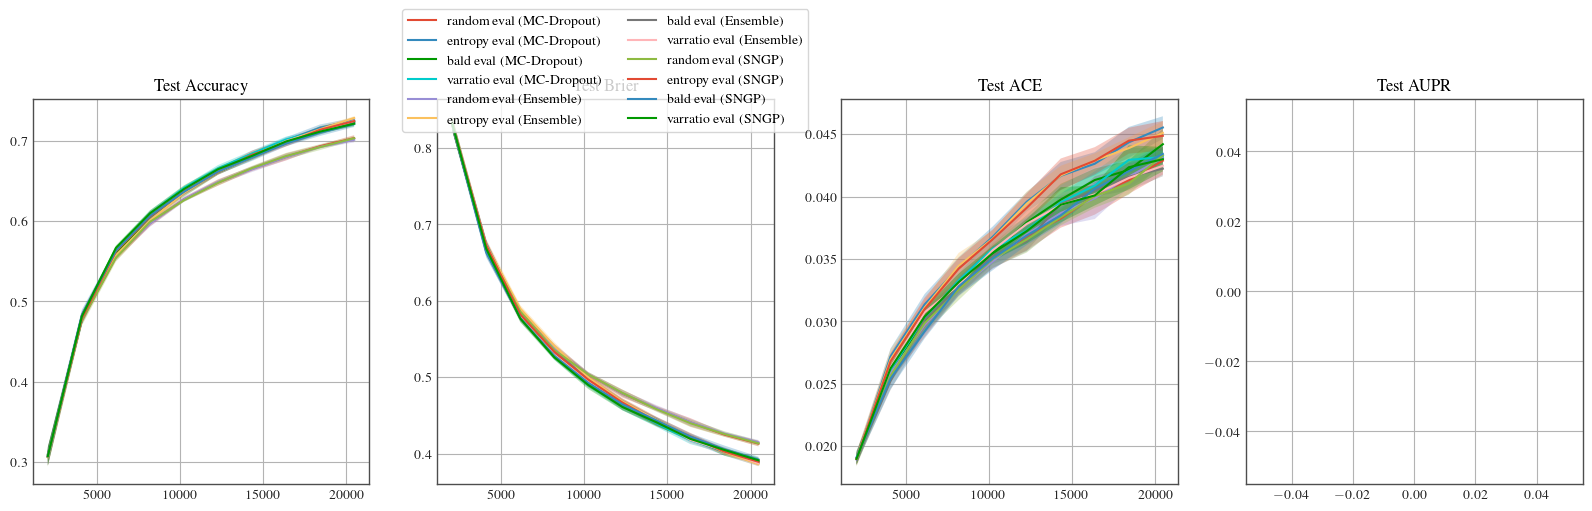

In [7]:
ood_datasets = ['CIFAR10', 'SVHN']
table_dict = {}
plt.figure(figsize=(20, 5))
show_std = True
for strat_name, results in tqdm(all_results.items()):

    test_accs = []
    test_nll = []
    test_brier = []
    test_tce = []
    test_ace = []
    test_aupr_near = []
    test_aupr_far = []
    n_labeled_samples = []
    for seed_result in results:
        data = seed_result['results']

        # Get metric values of interest
        n_labeled_samples.append([data[cycle]['n_labeled_samples'] for cycle in data])
        test_accs.append([data[cycle]['test_stats']['accuracy'] for cycle in data])
        test_nll.append([data[cycle]['test_stats']['nll'] for cycle in data])
        test_brier.append([data[cycle]['test_stats']['brier'] for cycle in data])
        test_tce.append([data[cycle]['test_stats']['tce'] for cycle in data])
        test_ace.append([data[cycle]['test_stats']['ace'] for cycle in data])
        test_aupr_near.append([data[cycle]['test_stats'].get(f'aupr_{ood_datasets[0]}', np.nan) for cycle in data])
        test_aupr_far.append([data[cycle]['test_stats'].get(f'aupr_{ood_datasets[1]}', np.nan) for cycle in data])

    n_labeled_samples = np.mean(n_labeled_samples, 0)
    test_accs_mean, test_accs_std = np.mean(test_accs, 0), np.std(test_accs, 0)
    test_nll_mean, test_nll_std = np.mean(test_nll, 0), np.std(test_nll, 0)
    test_brier_mean, test_brier_std = np.mean(test_brier, 0), np.std(test_brier, 0)
    test_tce_mean, test_tce_std = np.mean(test_tce, 0), np.std(test_tce, 0)
    test_ace_mean, test_ace_std = np.mean(test_ace, 0), np.std(test_ace, 0)
    test_aupr_far_mean, test_aupr_far_std = np.mean(test_aupr_far, 0), np.std(test_aupr_far, 0)
    test_aupr_near_mean, test_aupr_near_std = np.mean(test_aupr_near, 0), np.std(test_aupr_near, 0)

    table_dict[strat_name] = {
        'acc (Final)': test_accs_mean[-1], 
        'acc (AUC)': np.mean(test_accs_mean), 
        'brier (Final)': test_brier_mean[-1], 
        'brier (AUC)': np.mean(test_brier_mean), 
        'TCE (Final)': test_tce_mean[-1], 
        'TCE (AUC)': np.mean(test_tce_mean), 
        'ACE (Final)': test_ace_mean[-1], 
        'ACE (AUC)': np.mean(test_ace_mean), 
        'AUPR near (Final)': test_aupr_near_mean[-1],
        'AUPR near (AUC)': np.mean(test_aupr_near_mean),
        'AUPR far (Final)': test_aupr_far_mean[-1],
        'AUPR far (AUC)': np.mean(test_aupr_far_mean),
    }

    plt.subplot(141)
    plt.title('Test Accuracy')
    plt.plot(n_labeled_samples, test_accs_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)
    plt.subplot(142)
    plt.title('Test Brier')
    plt.plot(n_labeled_samples, test_brier_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_brier_mean-test_brier_std, test_brier_mean+test_brier_std, alpha=.3)
    plt.subplot(143)
    plt.title('Test ACE')
    plt.plot(n_labeled_samples, test_ace_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_ace_mean-test_ace_std, test_ace_mean+test_ace_std, alpha=.3)
    plt.subplot(144)
    plt.title('Test AUPR')
    plt.plot(n_labeled_samples, test_aupr_far_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_aupr_far_mean-test_aupr_far_std, test_aupr_far_mean+test_aupr_far_std, alpha=.3)
    # plt.plot(n_labeled_samples, test_aupr_svhn_mean, '-', label=strat_name)
    # plt.fill_between(n_labeled_samples, test_aupr_svhn_mean-test_aupr_svhn_std, test_aupr_svhn_mean+test_aupr_svhn_std, alpha=.3)

    # plt.subplot(144)
    # plt.title('Train Loss')
    # plt.plot(n_labeled_samples, train_loss_mean, '-', label=strat_name)
    # plt.fill_between(n_labeled_samples, train_loss_mean-train_loss_std, train_loss_mean+train_loss_std, alpha=.3)

plt.subplot(142).legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)
        

In [8]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict)
print(df.T[['acc (Final)', 'acc (AUC)', 'brier (Final)', 'brier (AUC)', 'ACE (Final)', 'ACE (AUC)', 'AUPR near (Final)', 'AUPR near (AUC)', 'AUPR far (Final)', 'AUPR far (AUC)']].to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & acc (Final) & acc (AUC) & brier (Final) & brier (AUC) & ACE (Final) & ACE (AUC) & AUPR near (Final) & AUPR near (AUC) & AUPR far (Final) & AUPR far (AUC) \\
\midrule
random eval (MC-Dropout) & 0.703 & 0.595 & 0.413 & 0.534 & 0.043 & 0.034 & NaN & NaN & NaN & NaN \\
entropy eval (MC-Dropout) & 0.725 & 0.607 & 0.388 & 0.524 & 0.046 & 0.036 & NaN & NaN & NaN & NaN \\
bald eval (MC-Dropout) & 0.722 & 0.606 & 0.390 & 0.522 & 0.044 & 0.035 & NaN & NaN & NaN & NaN \\
varratio eval (MC-Dropout) & 0.724 & 0.609 & 0.388 & 0.520 & 0.043 & 0.035 & NaN & NaN & NaN & NaN \\
random eval (Ensemble) & 0.701 & 0.595 & 0.415 & 0.534 & 0.043 & 0.034 & NaN & NaN & NaN & NaN \\
entropy eval (Ensemble) & 0.728 & 0.606 & 0.386 & 0.526 & 0.045 & 0.036 & NaN & NaN & NaN & NaN \\
bald eval (Ensemble) & 0.723 & 0.607 & 0.388 & 0.521 & 0.042 & 0.034 & NaN & NaN & NaN & NaN \\
varratio eval (Ensemble) & 0.725 & 0.607 & 0.387 & 0.522 & 0.042 & 0.035 & NaN & NaN & NaN & NaN \\

In [9]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict)
print(df.T[['brier (AUC)', 'ACE (AUC)', 'AUPR near (AUC)', 'AUPR far (AUC)']].to_latex(float_format="%.3f"))

\begin{tabular}{lrrrr}
\toprule
 & brier (AUC) & ACE (AUC) & AUPR near (AUC) & AUPR far (AUC) \\
\midrule
random eval (MC-Dropout) & 0.534 & 0.034 & NaN & NaN \\
entropy eval (MC-Dropout) & 0.524 & 0.036 & NaN & NaN \\
bald eval (MC-Dropout) & 0.522 & 0.035 & NaN & NaN \\
varratio eval (MC-Dropout) & 0.520 & 0.035 & NaN & NaN \\
random eval (Ensemble) & 0.534 & 0.034 & NaN & NaN \\
entropy eval (Ensemble) & 0.526 & 0.036 & NaN & NaN \\
bald eval (Ensemble) & 0.521 & 0.034 & NaN & NaN \\
varratio eval (Ensemble) & 0.522 & 0.035 & NaN & NaN \\
random eval (SNGP) & 0.534 & 0.034 & NaN & NaN \\
entropy eval (SNGP) & 0.524 & 0.036 & NaN & NaN \\
bald eval (SNGP) & 0.522 & 0.034 & NaN & NaN \\
varratio eval (SNGP) & 0.521 & 0.035 & NaN & NaN \\
\bottomrule
\end{tabular}



In [13]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict)
print(df.T[['acc (Final)', 'acc (AUC)']].to_latex(float_format="%.3f"))

\begin{tabular}{lrr}
\toprule
 & acc (Final) & acc (AUC) \\
\midrule
random eval (MC-Dropout) & 0.703 & 0.595 \\
entropy eval (MC-Dropout) & 0.725 & 0.607 \\
bald eval (MC-Dropout) & 0.722 & 0.606 \\
varratio eval (MC-Dropout) & 0.724 & 0.609 \\
random eval (Ensemble) & 0.701 & 0.595 \\
entropy eval (Ensemble) & 0.728 & 0.606 \\
bald eval (Ensemble) & 0.723 & 0.607 \\
varratio eval (Ensemble) & 0.725 & 0.607 \\
random eval (SNGP) & 0.703 & 0.595 \\
entropy eval (SNGP) & 0.724 & 0.607 \\
bald eval (SNGP) & 0.721 & 0.606 \\
varratio eval (SNGP) & 0.721 & 0.608 \\
\bottomrule
\end{tabular}



In [11]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict)
print(df.T[['brier (Final)', 'TCE (Final)', 'ACE (Final)']].to_latex(float_format="%.3f"))
# print(df.T[['brier (Final)', 'TCE (Final)', 'AUPR CIFAR100 (Final)', 'AUPR SVHN (Final)']].to_latex(float_format="%.3f"))

\begin{tabular}{lrrr}
\toprule
 & brier (Final) & TCE (Final) & ACE (Final) \\
\midrule
random eval (MC-Dropout) & 0.413 & 0.052 & 0.043 \\
entropy eval (MC-Dropout) & 0.388 & 0.057 & 0.046 \\
bald eval (MC-Dropout) & 0.390 & 0.053 & 0.044 \\
varratio eval (MC-Dropout) & 0.388 & 0.051 & 0.043 \\
random eval (Ensemble) & 0.415 & 0.054 & 0.043 \\
entropy eval (Ensemble) & 0.386 & 0.057 & 0.045 \\
bald eval (Ensemble) & 0.388 & 0.049 & 0.042 \\
varratio eval (Ensemble) & 0.387 & 0.049 & 0.042 \\
random eval (SNGP) & 0.413 & 0.053 & 0.043 \\
entropy eval (SNGP) & 0.389 & 0.056 & 0.045 \\
bald eval (SNGP) & 0.392 & 0.052 & 0.043 \\
varratio eval (SNGP) & 0.391 & 0.051 & 0.043 \\
\bottomrule
\end{tabular}



In [11]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict)
print(df.T[[f'AUPR near (Final)', f'AUPR far (Final)']].to_latex(float_format="%.3f"))
# print(df.T[['brier (Final)', 'TCE (Final)', 'AUPR CIFAR100 (Final)', 'AUPR SVHN (Final)']].to_latex(float_format="%.3f"))

\begin{tabular}{lrr}
\toprule
 & AUPR near (Final) & AUPR far (Final) \\
\midrule
random eval (MC-Dropout) & 0.706 & 0.898 \\
entropy eval (MC-Dropout) & 0.701 & 0.913 \\
bald eval (MC-Dropout) & 0.707 & 0.921 \\
varratio eval (MC-Dropout) & 0.705 & 0.919 \\
random eval (Ensemble) & 0.706 & 0.899 \\
entropy eval (Ensemble) & 0.703 & 0.915 \\
bald eval (Ensemble) & 0.708 & 0.904 \\
varratio eval (Ensemble) & 0.704 & 0.917 \\
random eval (SNGP) & 0.706 & 0.878 \\
entropy eval (SNGP) & 0.722 & 0.887 \\
bald eval (SNGP) & 0.719 & 0.884 \\
varratio eval (SNGP) & 0.714 & 0.881 \\
\bottomrule
\end{tabular}



# Overconfidence

In [10]:
root_path = Path('/mnt/work/dhuseljic/results/udal/')
dataset = 'CIFAR10'
experiments = {}
n_init = 128
acq_size = 128
num_cycles = 38

experiments.update({
    # 'random': root_path / f'overconfidence/{dataset}/resnet18/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'least conf': root_path / f'overconfidence/{dataset}/resnet18/least_confident/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'margin': root_path / f'overconfidence/{dataset}/resnet18/margin/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy': root_path / f'overconfidence/{dataset}/resnet18/entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})
experiments.update({
    # 'random (labelsmoothing)': root_path / f'overconfidence/{dataset}/resnet18_labelsmoothing/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'least conf (labelsmoothing)': root_path / f'overconfidence/{dataset}/resnet18_labelsmoothing/least_confident/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'margin (labelsmoothing)': root_path / f'overconfidence/{dataset}/resnet18_labelsmoothing/margin/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy (labelsmoothing)': root_path / f'overconfidence/{dataset}/resnet18_labelsmoothing/entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})
experiments.update({
    'random (mixup)': root_path / f'overconfidence/{dataset}/resnet18_mixup/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'least conf (mixup)': root_path / f'overconfidence/{dataset}/resnet18_mixup/least_confident/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'margin (mixup)': root_path / f'overconfidence/{dataset}/resnet18_mixup/margin/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'entropy (mixup)': root_path / f'overconfidence/{dataset}/resnet18_mixup/entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})

all_results = {}
for exp_name, exp_path in experiments.items():
    all_results[exp_name] = get_experiments(Path(exp_path), 'seed*', verify_only=False)

Searching in /mnt/work/dhuseljic/results/udal/overconfidence/CIFAR10/resnet18_mixup/random/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed7
> Found seed4
> Found seed9
> Found seed3
> Found seed1
> Found seed6
> Found seed2
> Found seed8
> Found seed10
> Found seed5
Searching in /mnt/work/dhuseljic/results/udal/overconfidence/CIFAR10/resnet18_mixup/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed10
> Found seed1
> Found seed6
> Found seed2
> Found seed8
> Found seed5
> Found seed7
> Found seed4
> Found seed9
> Found seed3
Searching in /mnt/work/dhuseljic/results/udal/overconfidence/CIFAR10/resnet18_mixup/margin/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed6
> Found seed1
> Found seed5
> Found seed8
> Found seed2
> Found seed10
> Found seed7
> Found seed3
> Found seed9
> Found seed4
Searching in /mnt/work/dhuseljic/results/udal/overconfidence/CIFAR10/resnet18_mixup/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed5
> Found seed2
> Found seed8
> Found seed6
> Found seed1
> Fou

100%|██████████| 4/4 [00:00<00:00, 25.12it/s]


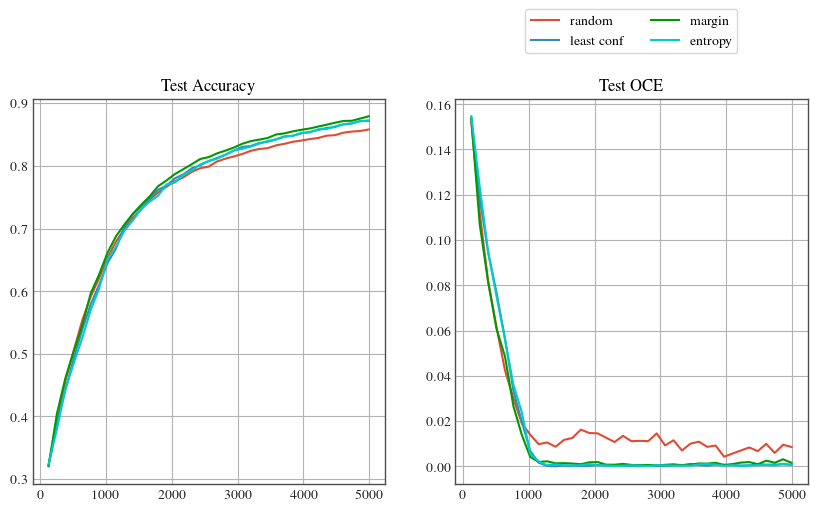

In [11]:
ood_datasets = ['CIFAR10', 'SVHN']
table_dict = {}
plt.figure(figsize=(10, 5))
show_std = True
for strat_name, results in tqdm(all_results.items()):

    test_accs = []
    test_oces = []
    n_labeled_samples = []
    for seed_result in results:
        data = seed_result['results']

        n_labeled_samples.append([data[cycle]['n_labeled_samples'] for cycle in data])
        test_accs.append([data[cycle]['test_stats']['accuracy'] for cycle in data])
        test_oces.append([data[cycle]['test_stats']['oce'] for cycle in data])

    n_labeled_samples = np.mean(n_labeled_samples, 0)
    test_accs_mean, test_accs_std = np.mean(test_accs, 0), np.std(test_accs, 0)
    test_oce_mean, test_oce_std = np.mean(test_oces, 0), np.std(test_oces, 0)

    table_dict[strat_name] = {
        'acc (Final)': test_accs_mean[-1], 
        'acc (AUC)': np.mean(test_accs_mean), 
        'OCE (Final)': test_oce_mean[-1], 
        'OCE (AUC)': np.mean(test_oce_mean), 
    }

    plt.subplot(121)
    plt.title('Test Accuracy')
    plt.plot(n_labeled_samples, test_accs_mean, '-', label=strat_name)
    # plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)
    plt.subplot(122)
    plt.title('Test OCE')
    plt.plot(n_labeled_samples, test_oce_mean, '-', label=strat_name)
    # plt.fill_between(n_labeled_samples, test_oce_mean-test_oce_std, test_oce_mean+test_oce_std, alpha=.3)

plt.subplot(122).legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)
        

In [12]:
import pandas as pd
df = pd.DataFrame(table_dict)
print(df.T.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrr}
\toprule
 & acc (Final) & acc (AUC) & OCE (Final) & OCE (AUC) \\
\midrule
random & 0.858 & 0.744 & 0.009 & 0.021 \\
least conf & 0.872 & 0.749 & 0.001 & 0.015 \\
margin & 0.879 & 0.756 & 0.002 & 0.014 \\
entropy & 0.873 & 0.747 & 0.001 & 0.015 \\
\bottomrule
\end{tabular}



In [34]:
import sys
sys.path.append('..')
from active_learning import build_datasets, build_model
from dal_toolbox.metrics.calibration import TopLabelCalibrationPlot

root_path = Path('/mnt/work/dhuseljic/results/udal/')
eval_type = 'overconfidence'
model_name = 'resnet18_labelsmoothing'
strat_name = 'random'

all_results = []
for exp_path in (root_path / f"{eval_type}/CIFAR10/{model_name}/{strat_name}/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{38}").glob('seed*'):
    print("Loading:", exp_path)
    checkpoint = torch.load(exp_path / 'model_final.pth')
    args =  OmegaConf.load(exp_path / '.hydra' / 'config.yaml')
    trainer = build_model(args, num_classes=10)
    model = trainer.model
    model.load_state_dict(checkpoint)
    args.dataset_path = '/datasets'
    data = build_datasets(args)

    print("Predicting...")
    test_loader = torch.utils.data.DataLoader(data.test_dataset, batch_size=256)

    logits_list = []
    targets_list = []
    model.cuda()
    model.eval()
    for inputs, targets in test_loader:
        with torch.no_grad():
            logits = model(inputs.cuda())
        logits_list.append(logits.cpu())
        targets_list.append(targets.cpu())

    logits = torch.cat(logits_list).cpu()
    targets = torch.cat(targets_list).cpu()

    tcp = TopLabelCalibrationPlot(num_bins=15)
    results = tcp(logits.softmax(-1), targets)
    all_results.append(results)

mean_confs =np.nanmean(np.stack([d['confs'] for d in all_results]), axis=0)
mean_accs = np.nanmean(np.stack([d['accs'] for d in all_results]), axis=0)
mean_n_samples = np.nanmean(np.stack([d['n_samples'] for d in all_results]), axis=0)


Loading: /mnt/work/dhuseljic/results/udal/overconfidence/CIFAR10/resnet18_labelsmoothing/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed10
Files already downloaded and verified
Files already downloaded and verified
Predicting...
Loading: /mnt/work/dhuseljic/results/udal/overconfidence/CIFAR10/resnet18_labelsmoothing/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed6
Files already downloaded and verified
Files already downloaded and verified
Predicting...
Loading: /mnt/work/dhuseljic/results/udal/overconfidence/CIFAR10/resnet18_labelsmoothing/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed1
Files already downloaded and verified
Files already downloaded and verified
Predicting...
Loading: /mnt/work/dhuseljic/results/udal/overconfidence/CIFAR10/resnet18_labelsmoothing/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed5
Files already downloaded and verified
Files already downloaded and verified
Predicting...
Loading: /mnt/work/dhuseljic/results/udal/overconfidence/CIFAR10/re

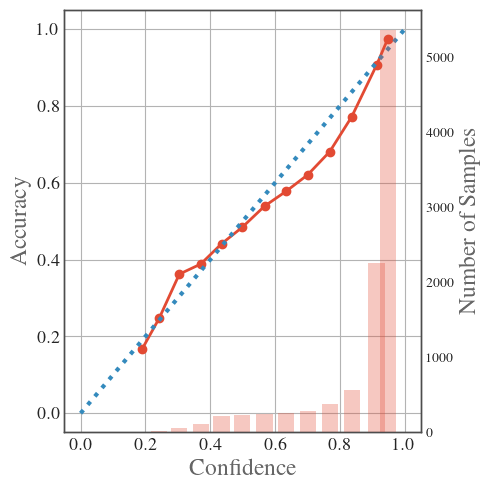

In [35]:
plt.figure(figsize=(5, 5))
plt.plot(mean_confs, mean_accs, '-o', linewidth=2)
plt.plot([0, 1], [0, 1], linewidth=3, linestyle=':')
plt.tick_params(labelsize=13)
plt.xlabel("Confidence", fontsize=17)
plt.ylabel("Accuracy", fontsize=17)
plt.twinx()
plt.ylabel("Number of Samples", fontsize=17)
plt.grid()
bar_x = [conf for conf in mean_confs if not np.isnan(conf)]
bar_y = [n for n in mean_n_samples if n != 0]
plt.bar(bar_x, bar_y, width=.05, alpha=.3)
plt.tight_layout()
os.makedirs('overconf_results', exist_ok=True)
plt.savefig(f'overconf_results/cal-plot_{model_name}_{strat_name}.pdf')
plt.show()

## Load a single Experiment

In [16]:
import sys
sys.path.append('..')
from active_learning import build_datasets, build_model

root_path = Path('/mnt/work/dhuseljic/results/udal/')
eval_type = 'overconfidence'
model_name = 'resnet18_labelsmoothing'
strat_name = 'least_confident'
exp_path = root_path / f"{eval_type}/CIFAR10/{model_name}/{strat_name}/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{38}/seed1"
checkpoint = torch.load(exp_path / 'model_final.pth')
args =  OmegaConf.load(exp_path / '.hydra' / 'config.yaml')

trainer = build_model(args, num_classes=10)
model = trainer.model
model.load_state_dict(checkpoint)

args.dataset_path = '/datasets'
data = build_datasets(args)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
test_loader = torch.utils.data.DataLoader(data.test_dataset, batch_size=256)

logits_list = []
targets_list = []
model.cuda()
model.eval()
for inputs, targets in test_loader:
    with torch.no_grad():
        logits = model(inputs.cuda())
    logits_list.append(logits.cpu())
    targets_list.append(targets.cpu())

logits = torch.cat(logits_list).cpu()
targets = torch.cat(targets_list).cpu()

Accuracy: 0.8734999895095825
ECE: 0.029381679370999336
ACE: 0.13966062664985657


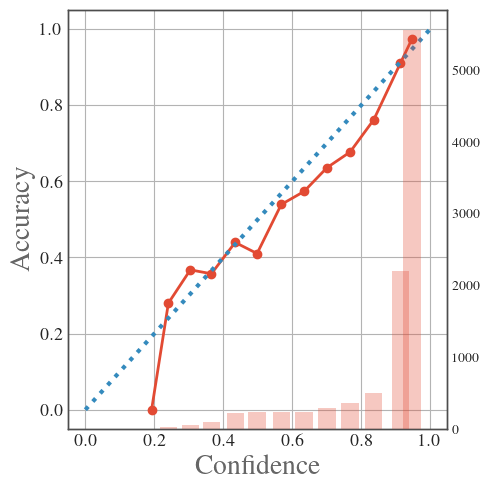

In [18]:
from dal_toolbox.metrics.calibration import ExpectedCalibrationError, TopLabelCalibrationError, AdaptiveCalibrationError
from dal_toolbox.metrics.generalization import Accuracy

acc_fn = Accuracy()
print('Accuracy: {}'.format(acc_fn(logits, targets)))
tce_fn = TopLabelCalibrationError(num_bins=15)
print('ECE: {}'.format(tce_fn(logits.softmax(-1), targets)))
ace_fn = AdaptiveCalibrationError()
print('ACE: {}'.format(ace_fn(logits.softmax(-1), targets)))
plt.figure(figsize=(5, 5))
plt.plot(tce_fn.results['confs'], tce_fn.results['accs'], '-o', linewidth=2)
plt.plot([0, 1], [0, 1], linewidth=3, linestyle=':')
plt.tick_params(labelsize=13)
plt.xlabel("Confidence", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.twinx()
plt.grid()
bar_x = [conf for conf in tce_fn.results['confs'] if not np.isnan(conf)]
bar_y = [n for n in tce_fn.results['n_samples'] if n != 0]
plt.bar(bar_x, bar_y, width=.05, alpha=.3)
plt.tight_layout()
plt.savefig(f'plots_al/cal-plot_{model_name}_{strat_name}.pdf')
plt.show()